In [1]:
import pathlib as pl
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd

import flopy
from flopy.utils.gridgen import Gridgen
from flopy.discretization import VertexGrid
from flopy.utils.triangle import Triangle as Triangle
from flopy.utils.gridintersect import GridIntersect

In [2]:
model_ws = "../temp/quadtree/"
grid_ws = f"{model_ws}grid/"
pl.Path(grid_ws).mkdir(parents=True, exist_ok=True)

output_folder = pl.Path('../figures')
output_folder.mkdir(parents=True, exist_ok=True)

Load a few raster files

In [3]:
bottom = flopy.utils.Raster.load("../data_project/aquifer_bottom.asc")
top = flopy.utils.Raster.load("../data_project/aquifer_top.asc")
kaq = flopy.utils.Raster.load("../data_project/aquifer_k.asc")

Load a few shapefiles with geopandas

In [4]:
river = gpd.read_file("../data_project/Flowline_river.shp")
inactive = gpd.read_file("../data_project/inactive_area.shp")
active = gpd.read_file("../data_project/active_area.shp")
wells = gpd.read_file("../data_project/pumping_well_locations.shp")

/Users/aleaf/mambaforge/envs/pyclass/lib/python3.11/site-packages/geopandas/geodataframe.py:1645: DeprecationWarning: Passing a SingleBlockManager to Series is deprecated and will raise in a future version. Use public APIs instead.
  srs = pd.Series(*args, **kwargs)
/Users/aleaf/mambaforge/envs/pyclass/lib/python3.11/site-packages/geopandas/geodataframe.py:1645: DeprecationWarning: Passing a SingleBlockManager to Series is deprecated and will raise in a future version. Use public APIs instead.
  srs = pd.Series(*args, **kwargs)
/Users/aleaf/mambaforge/envs/pyclass/lib/python3.11/site-packages/geopandas/geodataframe.py:1645: DeprecationWarning: Passing a SingleBlockManager to Series is deprecated and will raise in a future version. Use public APIs instead.
  srs = pd.Series(*args, **kwargs)
/Users/aleaf/mambaforge/envs/pyclass/lib/python3.11/site-packages/geopandas/geodataframe.py:1645: DeprecationWarning: Passing a SingleBlockManager to Series is deprecated and will raise in a future v

Plot the shapefiles with geopandas

/Users/aleaf/mambaforge/envs/pyclass/lib/python3.11/site-packages/pandas/core/frame.py:706: DeprecationWarning: Passing a BlockManager to GeoDataFrame is deprecated and will raise in a future version. Use public APIs instead.
  warnings.warn(
/Users/aleaf/mambaforge/envs/pyclass/lib/python3.11/site-packages/geopandas/geodataframe.py:1645: DeprecationWarning: Passing a SingleBlockManager to Series is deprecated and will raise in a future version. Use public APIs instead.
  srs = pd.Series(*args, **kwargs)
/Users/aleaf/mambaforge/envs/pyclass/lib/python3.11/site-packages/geopandas/geodataframe.py:1645: DeprecationWarning: Passing a SingleBlockManager to Series is deprecated and will raise in a future version. Use public APIs instead.
  srs = pd.Series(*args, **kwargs)
/Users/aleaf/mambaforge/envs/pyclass/lib/python3.11/site-packages/geopandas/geodataframe.py:1645: DeprecationWarning: Passing a SingleBlockManager to Series is deprecated and will raise in a future version. Use public APIs 

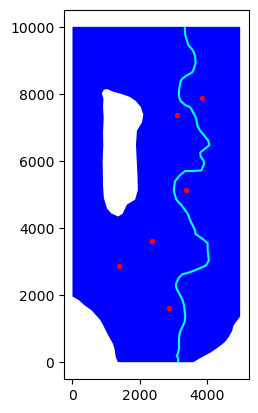

In [5]:
ax = river.plot(color="cyan")
active.plot(ax=ax, color="blue")
inactive.plot(ax=ax, color="white")
wells.plot(ax=ax, color="red", markersize=8);

#### Make a quadtree grid

In [6]:
# quadtree grid
sim = flopy.mf6.MFSimulation()
gwf = flopy.mf6.ModflowGwf(sim)
dx = dy = 250.0
nrow = 40
ncol = 20
dis6 = flopy.mf6.ModflowGwfdis(
    gwf,
    nrow=nrow,
    ncol=ncol,
    delr=dy,
    delc=dx,
)
g = Gridgen(dis6, model_ws=grid_ws)

/Users/aleaf/mambaforge/envs/pyclass/lib/python3.11/site-packages/flopy/utils/gridgen.py:232: UserWarning: Supplying a dis object is deprecated, and support will be removed in version 3.3.7. Please supply StructuredGrid.
  warnings.warn(


In [7]:
river_pth = (pl.Path("../data_project") / "Flowline_river").resolve()
well_pth = (pl.Path("../data_project") / "pumping_well_locations").resolve()
river_pth, well_pth

(PosixPath('/Users/aleaf/Documents/Python_course/python-for-hydrology/notebooks/part1_flopy/data_project/Flowline_river'),
 PosixPath('/Users/aleaf/Documents/Python_course/python-for-hydrology/notebooks/part1_flopy/data_project/pumping_well_locations'))

In [8]:
g.add_refinement_features(str(river_pth), "line", 4, range(1))
g.add_refinement_features(str(well_pth), "point", 4, range(1))

In [9]:
g.build(verbose=False)

In [10]:
gridprops = g.get_gridprops_vertexgrid()
base_grid = VertexGrid(**gridprops)

In [11]:
gridprops.keys()

dict_keys(['nlay', 'ncpl', 'top', 'botm', 'vertices', 'cell2d'])

/Users/aleaf/mambaforge/envs/pyclass/lib/python3.11/site-packages/pandas/core/frame.py:706: DeprecationWarning: Passing a BlockManager to GeoDataFrame is deprecated and will raise in a future version. Use public APIs instead.
  warnings.warn(
/Users/aleaf/mambaforge/envs/pyclass/lib/python3.11/site-packages/geopandas/geodataframe.py:1645: DeprecationWarning: Passing a SingleBlockManager to Series is deprecated and will raise in a future version. Use public APIs instead.
  srs = pd.Series(*args, **kwargs)
/Users/aleaf/mambaforge/envs/pyclass/lib/python3.11/site-packages/geopandas/geodataframe.py:1645: DeprecationWarning: Passing a SingleBlockManager to Series is deprecated and will raise in a future version. Use public APIs instead.
  srs = pd.Series(*args, **kwargs)
/Users/aleaf/mambaforge/envs/pyclass/lib/python3.11/site-packages/geopandas/geodataframe.py:1645: DeprecationWarning: Passing a SingleBlockManager to Series is deprecated and will raise in a future version. Use public APIs 

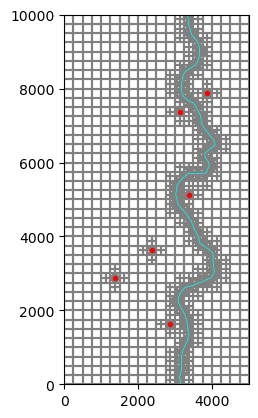

In [12]:
base_grid.plot()
river.plot(color="cyan", ax=plt.gca(), linewidth=0.5)
wells.plot(ax=plt.gca(), color="red", markersize=8, zorder=100);

#### Define the number of layers and some simple shapes

In [13]:
nlay = 3
shape2d, shape3d = (base_grid.ncpl), (nlay, base_grid.ncpl)
xlen, ylen = 5000.0, 10000.0

### Intersect the modelgrid with the shapefiles

#### Create an intersection object

In [14]:
ix = GridIntersect(base_grid, method="vertex", rtree=True)

#### Intersect inactive and active shapefiles with the modelgrid

After all of the intersection operations, take a look at the data contained in the returned objects

In [15]:
bedrock = ix.intersect(inactive.geometry[0])
active_cells = ix.intersect(active.geometry[0])

/Users/aleaf/mambaforge/envs/pyclass/lib/python3.11/site-packages/geopandas/geodataframe.py:1645: DeprecationWarning: Passing a SingleBlockManager to Series is deprecated and will raise in a future version. Use public APIs instead.
  srs = pd.Series(*args, **kwargs)
/Users/aleaf/mambaforge/envs/pyclass/lib/python3.11/site-packages/geopandas/geodataframe.py:1645: DeprecationWarning: Passing a SingleBlockManager to Series is deprecated and will raise in a future version. Use public APIs instead.
  srs = pd.Series(*args, **kwargs)


In [16]:
active_cells[:4], active_cells.dtype

(rec.array([(0, <POLYGON ((250 10000, 250 9750, 0 9750, 0 10000, 250 10000))>, 62500.),
            (1, <POLYGON ((500 10000, 500 9750, 250 9750, 250 10000, 500 10000))>, 62500.),
            (2, <POLYGON ((750 10000, 750 9750, 500 9750, 500 10000, 750 10000))>, 62500.),
            (3, <POLYGON ((1000 10000, 1000 9750, 750 9750, 750 10000, 1000 10000))>, 62500.)],
           dtype=[('cellids', 'O'), ('ixshapes', 'O'), ('areas', '<f8')]),
 dtype((numpy.record, [('cellids', 'O'), ('ixshapes', 'O'), ('areas', '<f8')])))

#### Intersect well shapefile with the modelgrid

In [17]:
well_cells = []
for g in wells.geometry:
    v = ix.intersect(g)
    well_cells += v["cellids"].tolist()

/Users/aleaf/mambaforge/envs/pyclass/lib/python3.11/site-packages/geopandas/geodataframe.py:1645: DeprecationWarning: Passing a SingleBlockManager to Series is deprecated and will raise in a future version. Use public APIs instead.
  srs = pd.Series(*args, **kwargs)


In [18]:
well_cells

[1003, 1220, 2562, 3221, 3604, 4385]

#### Intersect river shapefile with the modelgrid

In [19]:
river_cells = ix.intersect(river.geometry[0])

/Users/aleaf/mambaforge/envs/pyclass/lib/python3.11/site-packages/geopandas/geodataframe.py:1645: DeprecationWarning: Passing a SingleBlockManager to Series is deprecated and will raise in a future version. Use public APIs instead.
  srs = pd.Series(*args, **kwargs)


In [20]:
river_cells[:4], river_cells.dtype

(rec.array([(18, <LINESTRING (3347.204 10000, 3348.246 9984.375)>, 15.65968373),
            (20, <LINESTRING (3348.246 9984.375, 3349.287 9968.75)>, 15.65968373),
            (23, <LINESTRING (3349.287 9968.75, 3350.329 9953.125)>, 15.65968373),
            (25, <LINESTRING (3350.329 9953.125, 3351.371 9937.5)>, 15.65968373)],
           dtype=[('cellids', 'O'), ('ixshapes', 'O'), ('lengths', '<f8')]),
 dtype((numpy.record, [('cellids', 'O'), ('ixshapes', 'O'), ('lengths', '<f8')])))

### Intersect constant head line with the modelgrid

Use a line with two points to defined the location of the constant head cells. The line verticase are `[(1250, 0.1), (4250, 0.1)]`.

In [21]:
constant_cells = ix.intersect(
    [(1250, 0.1), (4250, 0.1)], shapetype="linestring"
)

In [22]:
constant_cells[:4], constant_cells.dtype

(rec.array([(5018, <LINESTRING (1250 0.1, 1500 0.1)>, 250.),
            (5019, <LINESTRING (1500 0.1, 1750 0.1)>, 250.),
            (5020, <LINESTRING (1750 0.1, 2000 0.1)>, 250.),
            (5021, <LINESTRING (2000 0.1, 2250 0.1)>, 250.)],
           dtype=[('cellids', 'O'), ('ixshapes', 'O'), ('lengths', '<f8')]),
 dtype((numpy.record, [('cellids', 'O'), ('ixshapes', 'O'), ('lengths', '<f8')])))

### Resample the raster data to the modelgrid

Use the `resample_to_grid()` method on each raster object.

In [23]:
rtop = top.resample_to_grid(
    base_grid,
    band=top.bands[0],
    method="linear",
    extrapolate_edges=True,
)
rbot = bottom.resample_to_grid(
    base_grid,
    band=bottom.bands[0],
    method="linear",
    extrapolate_edges=True,
)
rkaq = (
    kaq.resample_to_grid(
        base_grid, band=kaq.bands[0], method="linear", extrapolate_edges=True
    )
    * 86400.0
)

### Plot the resampled data 

Plot the aquifer top, bottom, and hydraulic conductivity. Also plot the aquifer thickness.

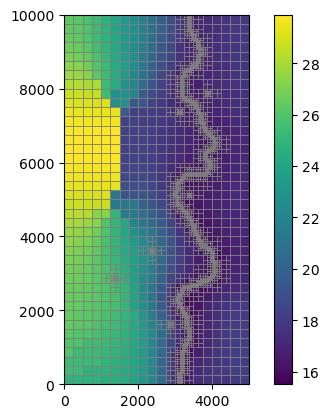

In [24]:
mm = flopy.plot.PlotMapView(modelgrid=base_grid)
cb = mm.plot_array(rtop)
mm.plot_grid(lw=0.5, color="0.5")
plt.colorbar(cb, ax=plt.gca());

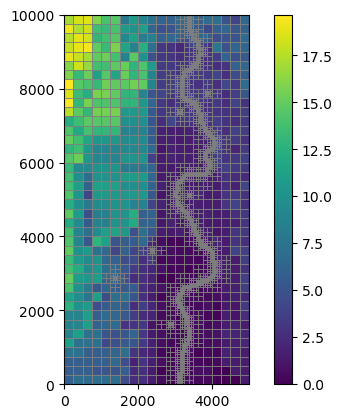

In [25]:
mm = flopy.plot.PlotMapView(modelgrid=base_grid)
cb = mm.plot_array(rbot)
mm.plot_grid(lw=0.5, color="0.5")
plt.colorbar(cb, ax=plt.gca());

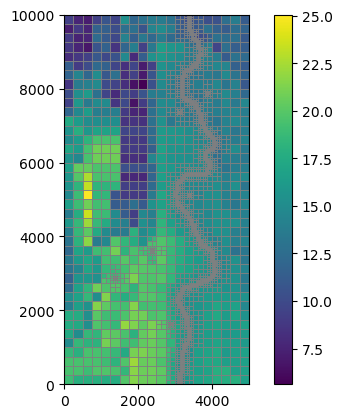

In [26]:
mm = flopy.plot.PlotMapView(modelgrid=base_grid)
cb = mm.plot_array(rtop - rbot)
mm.plot_grid(lw=0.5, color="0.5")
plt.colorbar(cb);

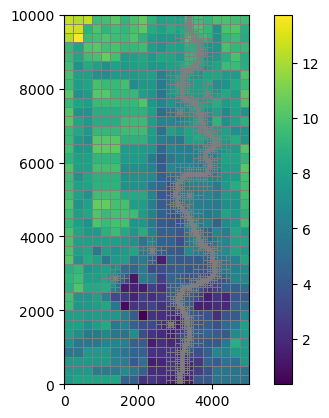

In [27]:
mm = flopy.plot.PlotMapView(modelgrid=base_grid)
cb = mm.plot_array(rkaq)
mm.plot_grid(lw=0.5, color="0.5")
plt.colorbar(cb);

#### Build the model data

_Create the bottom of each model layer_

Assume that the thickness of each layer at a row, column location is equal.

In [28]:
botm = np.zeros(shape3d, dtype=float)
botm[-1, :] = rbot[:]
layer_thickness = (rtop - rbot) / nlay
for k in reversed(range(nlay - 1)):
    botm[k] = botm[k + 1] + layer_thickness

_Create the idomain array_

Use the intersection data from the active and inactive shapefiles to create the idomain array

In [29]:
idomain = np.zeros(shape3d, dtype=float)
for node in active_cells["cellids"]:
    idomain[:, node] = 1
for node in bedrock["cellids"]:
    idomain[:, node] = 0

_Build the well package stress period data_

* The pumping rates are in the `wells` geopandas dataframe
* Pumping rates are in m/sec
* The wells are located in model layer 3

In [30]:
wells

/Users/aleaf/mambaforge/envs/pyclass/lib/python3.11/site-packages/geopandas/geodataframe.py:1645: DeprecationWarning: Passing a SingleBlockManager to Series is deprecated and will raise in a future version. Use public APIs instead.
  srs = pd.Series(*args, **kwargs)
/Users/aleaf/mambaforge/envs/pyclass/lib/python3.11/site-packages/geopandas/geodataframe.py:1645: DeprecationWarning: Passing a SingleBlockManager to Series is deprecated and will raise in a future version. Use public APIs instead.
  srs = pd.Series(*args, **kwargs)
/Users/aleaf/mambaforge/envs/pyclass/lib/python3.11/site-packages/geopandas/geodataframe.py:1645: DeprecationWarning: Passing a SingleBlockManager to Series is deprecated and will raise in a future version. Use public APIs instead.
  srs = pd.Series(*args, **kwargs)
/Users/aleaf/mambaforge/envs/pyclass/lib/python3.11/site-packages/geopandas/geodataframe.py:1645: DeprecationWarning: Passing a SingleBlockManager to Series is deprecated and will raise in a future v

,FID,Q,geometry
0,0,-0.00820,POINT (3875.000 7875.000)
1,1,-0.00410,POINT (3125.000 7375.000)
2,2,-0.00390,POINT (3375.000 5125.000)
3,3,-0.00083,POINT (2375.000 3625.000)
4,4,-0.00072,POINT (1375.000 2875.000)
5,5,-0.00430,POINT (2875.000 1625.000)


In [31]:
well_spd = []
for (cellid, q) in zip(well_cells, wells["Q"]):
    well_spd.append([2, cellid, q * 86400.0])
well_spd

/Users/aleaf/mambaforge/envs/pyclass/lib/python3.11/site-packages/geopandas/geodataframe.py:1645: DeprecationWarning: Passing a SingleBlockManager to Series is deprecated and will raise in a future version. Use public APIs instead.
  srs = pd.Series(*args, **kwargs)


[[2, 1003, -708.48],
 [2, 1220, -354.24],
 [2, 2562, -336.96],
 [2, 3221, -71.712],
 [2, 3604, -62.208000000000006],
 [2, 4385, -371.52]]

_Build the river package stress period data_

* Calculate the length of the river using the `"lengths"` key. 
* The vertical hydraulic conductivity of the river bed sediments is 3.5 m/d.
* The thickness of river bottom sediments at the upstream (North) and downstream (South) end of the river is 0.5 and 1.5 meters, respectively. 
* The river bottom at the upstream and downstream end of the river is 16.5 and 14.5 meters, respectively. The river width at the upstream and downstream end of the river is 5.0 and 10.0 meters, respectively. 
* The river stage at the upstream and downstream end of the river is 16.6 and 15.5 meters, respectively.
* Use the boundname `upstream` for river cells where the upstream end of the river cell is less than 5000 m from the North end of the model. Use the boundname `downstream` for all other river cells.

Use the upstream and downstream values to interpolate the river sediment thickness, bottom, width, and stage for each river cell.

The river cells will be conected to model layer 1. The river bottom, width, and stage values should be calculated at the center of the river reach.

In [32]:
river_kv = 3.5
river_thickness_up, river_thickness_down = 0.5, 1.5
river_bot_up, river_bot_down = 16.5, 14.5
river_width_up, river_width_down = 5.0, 10.0
stage_up, stage_down = 16.6, 15.5

In [33]:
river_length = river_cells["lengths"].sum()
river_length

12419.290359618695

In [34]:
river_thickness_slope = (
    river_thickness_down - river_thickness_up
) / river_length

In [35]:
river_bot_slope = (river_bot_down - river_bot_up) / river_length

In [36]:
river_width_slope = (river_width_down - river_width_up) / river_length

In [37]:
stage_slope = (stage_down - stage_up) / river_length

In [38]:
boundname = "upstream"
total_length = 0.0
river_spd = []
river_top_delta = []
for idx, (cellid, length) in enumerate(
    zip(river_cells["cellids"], river_cells["lengths"])
):
    if total_length >= 5000.0 and boundname == "upstream":
        boundname = "downstream"
    dx = 0.5 * length
    total_length += dx

    river_thickness = river_thickness_up + river_thickness_slope * total_length
    river_bot = river_bot_up + river_bot_slope * total_length
    river_width = river_width_up + river_width_slope * total_length
    river_stage = stage_up + stage_slope * total_length
    conductance = river_kv * length * river_width / river_thickness
    river_spd.append(
        [0, cellid, river_stage, conductance, river_bot, boundname]
    )
    river_top_delta.append(river_bot - rtop[cellid])

    total_length += dx
river_top_delta = np.array(river_top_delta)
river_spd[:2], river_spd[-2:]

([[0,
   18,
   16.599306496120093,
   547.7438185279854,
   16.498739083854712,
   'upstream'],
  [0,
   20,
   16.597919488360276,
   547.056195764861,
   16.496217251564133,
   'upstream']],
 [[0,
   5093,
   15.502077782281075,
   365.0282982693656,
   14.50377778596559,
   'downstream'],
  [0,
   5095,
   15.500692594093692,
   364.9515826007674,
   14.50125926198853,
   'downstream']])

In [39]:
river_top_delta.min(), river_top_delta.max(), river_top_delta.mean(), river_top_delta[
    -2:
]

(-1.2690004091658569,
 -0.09015671387478008,
 -0.6221983009423475,
 array([-1.00821085, -1.01072938]))

_Define river observations_

In [40]:
riv_obs = {
    "riv_obs.csv": [
        ("UPSTREAM", "RIV", "UPSTREAM"),
        ("DOWNSTREAM", "RIV", "DOWNSTREAM"),
    ],
}

_Build SFR datasets_

`<rno> <cellid(ncelldim)> <rlen> <rwid> <rgrd> <rtp> <rbth> <rhk> <man> <ncon> <ustrf> <ndv> [<aux(naux)>] [<boundname>]`

In [41]:
nreaches = river_cells.shape[0]
nreaches

1000

In [42]:
boundname = "upstream"
gage1_loc = None
total_length = 0.0
sfr_packagedata = []
sfr_connectivity = []
for idx, (cellid, length) in enumerate(
    zip(river_cells["cellids"], river_cells["lengths"])
):
    if total_length >= 5000.0 and boundname == "upstream":
        boundname = "downstream"
        gage1_loc = idx - 1
    dx = 0.5 * length
    total_length += dx

    river_thickness = river_thickness_up + river_thickness_slope * total_length
    river_bot = river_bot_up + river_bot_slope * total_length
    river_width = river_width_up + river_width_slope * total_length

    if idx == 0:
        nconn = 1
        sfr_connectivity.append((idx, -(idx + 1)))
    elif idx == nreaches - 1:
        nconn = 1
        sfr_connectivity.append((idx, (idx - 1)))
    else:
        nconn = 2
        sfr_connectivity.append((idx, (idx - 1), -(idx + 1)))

    sfr_layer = None
    for k in range(nlay):
        if river_bot - river_thickness > botm[k, cellid]:
            sfr_layer = k

    if sfr_layer is None:
        sfr_cellid = "none"
    else:
        sfr_cellid = (sfr_layer, cellid)

    leakance = river_kv * river_thickness
    sfr_packagedata.append(
        (
            idx,
            sfr_cellid,
            length,
            river_width,
            -river_bot_slope,
            river_bot,
            river_thickness,
            river_kv,
            0.035,
            nconn,
            1.0,
            0,
            boundname,
        )
    )

    total_length += dx

In [43]:
sfr_spd = {0: [(0, "inflow", 864000.0)]}
sfr_spd

{0: [(0, 'inflow', 864000.0)]}

`<rno> <cellid(ncelldim)> <rlen> <rwid> <rgrd> <rtp> <rbth> <rhk> <man> <ncon> <ustrf> <ndv> [<aux(naux)>] [<boundname>]`

In [44]:
sfr_packagedata[:2], sfr_packagedata[-2:]

([(0,
   (2, 18),
   15.6596837274718,
   5.0031522903632215,
   0.00016103979712906924,
   16.498739083854712,
   0.5006304580726444,
   3.5,
   0.035,
   1,
   1.0,
   0,
   'upstream'),
  (1,
   (2, 20),
   15.65968372747177,
   5.009456871089665,
   0.00016103979712906924,
   16.496217251564133,
   0.5018913742179331,
   3.5,
   0.035,
   2,
   1.0,
   0,
   'upstream')],
 [(998,
   (2, 5093),
   15.63914027438707,
   9.990555535086022,
   0.00016103979712906924,
   14.50377778596559,
   1.4981111070172046,
   3.5,
   0.035,
   2,
   1.0,
   0,
   'downstream'),
  (999,
   (2, 5095),
   15.639140274387051,
   9.996851845028672,
   0.00016103979712906924,
   14.50125926198853,
   1.4993703690057347,
   3.5,
   0.035,
   1,
   1.0,
   0,
   'downstream')])

In [45]:
sfr_connectivity[:2], sfr_connectivity[-2:]

([(0, -1), (1, 0, -2)], [(998, 997, -999), (999, 998)])

In [46]:
sfr_obs = {
    "sfr_obs.csv": [
        ("UPSTREAM", "SFR", "UPSTREAM"),
        ("DOWNSTREAM", "SFR", "DOWNSTREAM"),
        ("GAGE1", "downstream-flow", (gage1_loc,)),
        ("GAGE2", "ext-outflow", (nreaches - 1,)),
    ],
}

_Define the constant head cells_

Assume the constant head cells are located in all three layers and have values equal to the downstream river stage (`stage_down`). Make sure the constant head stage is greater that the bottom of the layer.

In [47]:
chd_spd = []
for node in constant_cells["cellids"]:
    for k in range(nlay):
        if stage_down > botm[k, node]:
            chd_spd.append((k, node, stage_down))
chd_spd[:2], chd_spd[-2:]

([(1, 5018, 15.5), (2, 5018, 15.5)], [(1, 5104, 15.5), (2, 5104, 15.5)])

_Define recharge rates_

* The recharge rate is 0.16000000E-08 m/sec

In [48]:
recharge_rate = 0.16000000e-08 * 86400.0
recharge_rate

0.00013824

#### Build the model

Build a steady-state model using the data that you have created. Packages to create:

* Simulation
* TDIS (1 stress period, `TIME_UNITS='days'`)
* IMS (default parameters)

* GWF model (`SAVE_FLOWS=True`)
* DISV (`LENGTH_UNITS='meters'`)
* IC (`STRT=40.`)
* NPF (Unconfined, same K for all layers, save `SAVE_SPECIFIC_DISCHARGE=True`)
* RCH (array based)
* SFR (`BOUNDNAMES=True`,add `SFR` observations for defined boundnames)
* CHD
* WEL
* OC (Save `HEAD ALL` and `BUDGET ALL`)


In [49]:
name = "project"
# exe_name = pl.Path("/Users/jdhughes/Documents/Training/python-for-hydrology/notebooks/part1_flopy/day0").resolve() / "mf6"  #"/Users/jdhughes/Documents/Development/modflow6/modflow6/bin/mf6"
exe_name = "mf6"
exe_name

'mf6'

In [50]:
sim = flopy.mf6.MFSimulation(
    sim_name=name, sim_ws=model_ws, exe_name=str(exe_name)
)
tdis = flopy.mf6.ModflowTdis(sim, time_units="days")
ims = flopy.mf6.ModflowIms(
    sim,
    linear_acceleration="bicgstab",
    outer_maximum=200,
    inner_maximum=100,
    print_option="all",
)

In [51]:
gwf = flopy.mf6.ModflowGwf(
    sim,
    modelname=name,
    save_flows=True,
    newtonoptions="NEWTON UNDER_RELAXATION",
)

In [52]:
dis = flopy.mf6.ModflowGwfdisv(
    gwf,
    length_units="meters",
    nlay=nlay,
    ncpl=base_grid.ncpl,
    nvert=base_grid.nvert,
    vertices=gridprops["vertices"],
    cell2d=gridprops["cell2d"],
    top=rtop,
    botm=botm,
    idomain=idomain,
)
ic = flopy.mf6.ModflowGwfic(gwf, strt=[rtop for k in range(nlay)])
npf = flopy.mf6.ModflowGwfnpf(
    gwf, save_specific_discharge=True, k=[rkaq, rkaq, rkaq], icelltype=1
)
rch = flopy.mf6.ModflowGwfrcha(gwf, recharge=recharge_rate)
# riv = flopy.mf6.ModflowGwfriv(gwf, boundnames=True, stress_period_data=river_spd)
# riv.obs.initialize(
#     filename=f"{name}.riv.obs",
#     print_input=True,
#     continuous=riv_obs,
# )
sfr = flopy.mf6.ModflowGwfsfr(
    gwf,
    unit_conversion=86400.0,
    boundnames=True,
    print_flows=True,
    print_stage=True,
    nreaches=nreaches,
    packagedata=sfr_packagedata,
    connectiondata=sfr_connectivity,
    perioddata=sfr_spd,
)
sfr.obs.initialize(
    filename=f"{name}.sfr.obs",
    print_input=True,
    continuous=sfr_obs,
)
wel = flopy.mf6.ModflowGwfwel(gwf, stress_period_data=well_spd)
chd = flopy.mf6.ModflowGwfchd(gwf, stress_period_data=chd_spd)
oc = flopy.mf6.ModflowGwfoc(
    gwf,
    head_filerecord=f"{name}.hds",
    budget_filerecord=f"{name}.cbc",
    saverecord=[("HEAD", "ALL"), ("BUDGET", "ALL")],
)

#### Write the model files

In [53]:
sim.write_simulation()

writing simulation...
  writing simulation name file...
  writing simulation tdis package...
  writing solution package ims_-1...
  writing model project...
    writing model name file...
    writing package disv...
    writing package ic...
    writing package npf...
    writing package rcha_0...
    writing package sfr_0...
    writing package obs_0...
    writing package wel_0...
INFORMATION: maxbound in ('gwf6', 'wel', 'dimensions') changed to 6 based on size of stress_period_data
    writing package chd_0...
INFORMATION: maxbound in ('gwf6', 'chd', 'dimensions') changed to 56 based on size of stress_period_data
    writing package oc...


#### Run the model

In [54]:
sim.run_simulation()

FloPy is using the following executable to run the model: ../../../../../../software/modflow_exes/mf6
                                   MODFLOW 6
                U.S. GEOLOGICAL SURVEY MODULAR HYDROLOGIC MODEL
                            VERSION 6.4.2 06/28/2023

   MODFLOW 6 compiled Jun 28 2023 18:34:54 with Intel(R) Fortran Intel(R) 64
   Compiler Classic for applications running on Intel(R) 64, Version 2021.7.0
                             Build 20220726_000000

This software has been approved for release by the U.S. Geological 
Survey (USGS). Although the software has been subjected to rigorous 
review, the USGS reserves the right to update the software as needed 
pursuant to further analysis and review. No warranty, expressed or 
implied, is made by the USGS or the U.S. Government as to the 
functionality of the software and related material nor shall the 
fact of release constitute any such warranty. Furthermore, the 
software is released on condition that neither the USGS nor 

(True, [])

#### Post-process the results

Use `gwf.output.` method to get the observations.

In [55]:
myobs = gwf.sfr.output.obs().get_data()
myobs.dtype

dtype([('totim', '<f8'), ('UPSTREAM', '<f8'), ('DOWNSTREAM', '<f8'), ('GAGE1', '<f8'), ('GAGE2', '<f8')])

In [56]:
myobs["UPSTREAM"], myobs["DOWNSTREAM"]

(array([-1139.41061029]), array([-1905.93621052]))

Use `gwf.output.` method to get the heads and specific discharge. Make a map and cross-sections of the data using `flopy.plot` methods. Plot specific discharge vectors on the map and cross-sections.

In [57]:
head = gwf.output.head().get_data()

In [58]:
gwf.output.budget().get_unique_record_names()

[b'    FLOW-JA-FACE',
 b'      DATA-SPDIS',
 b'             WEL',
 b'            RCHA',
 b'             CHD',
 b'             SFR']

In [59]:
spdis = gwf.output.budget().get_data(text="DATA-SPDIS")[0]
qx, qy, qz = flopy.utils.postprocessing.get_specific_discharge(
    spdis, gwf, head=head
)

/Users/aleaf/mambaforge/envs/pyclass/lib/python3.11/site-packages/pandas/core/frame.py:706: DeprecationWarning: Passing a BlockManager to GeoDataFrame is deprecated and will raise in a future version. Use public APIs instead.
  warnings.warn(
/Users/aleaf/mambaforge/envs/pyclass/lib/python3.11/site-packages/geopandas/geodataframe.py:1645: DeprecationWarning: Passing a SingleBlockManager to Series is deprecated and will raise in a future version. Use public APIs instead.
  srs = pd.Series(*args, **kwargs)
/Users/aleaf/mambaforge/envs/pyclass/lib/python3.11/site-packages/geopandas/geodataframe.py:1645: DeprecationWarning: Passing a SingleBlockManager to Series is deprecated and will raise in a future version. Use public APIs instead.
  srs = pd.Series(*args, **kwargs)
/Users/aleaf/mambaforge/envs/pyclass/lib/python3.11/site-packages/geopandas/geodataframe.py:1645: DeprecationWarning: Passing a SingleBlockManager to Series is deprecated and will raise in a future version. Use public APIs 

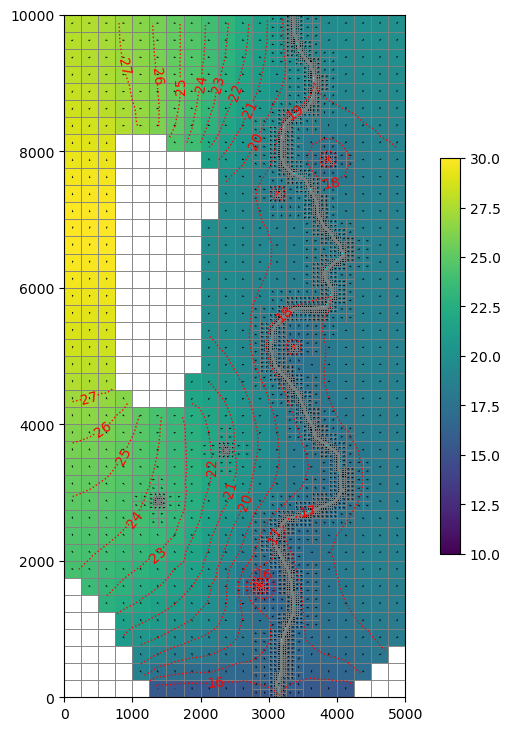

In [60]:
fig, ax = plt.subplots(
    ncols=1,
    nrows=1,
    figsize=(5, 8),
    constrained_layout=True,
    subplot_kw=dict(aspect="equal"),
)
mm = flopy.plot.PlotMapView(model=gwf, ax=ax, layer=0)
cb = mm.plot_array(head, masked_values=[1e30], vmin=10, vmax=30)
river.plot(color="cyan", ax=mm.ax)
mm.plot_grid(lw=0.5, color="0.5")
mm.plot_vector(qx, qy, qz, normalize=True)
cs = mm.contour_array(
    head,
    colors="red",
    levels=np.arange(10, 28, 1),
    linestyles=":",
    linewidths=1.0,
)
ax.clabel(
    cs,
    inline=True,
    fmt="%1.0f",
    fontsize=10,
    inline_spacing=0.5,
)
plt.colorbar(cb, ax=mm.ax, shrink=0.5)

fig.savefig(output_folder / "freyberg-quadtree.png", dpi=300);

/Users/aleaf/mambaforge/envs/pyclass/lib/python3.11/site-packages/pandas/core/frame.py:706: DeprecationWarning: Passing a BlockManager to GeoDataFrame is deprecated and will raise in a future version. Use public APIs instead.
  warnings.warn(
/Users/aleaf/mambaforge/envs/pyclass/lib/python3.11/site-packages/geopandas/geodataframe.py:1645: DeprecationWarning: Passing a SingleBlockManager to Series is deprecated and will raise in a future version. Use public APIs instead.
  srs = pd.Series(*args, **kwargs)
/Users/aleaf/mambaforge/envs/pyclass/lib/python3.11/site-packages/geopandas/geodataframe.py:1645: DeprecationWarning: Passing a SingleBlockManager to Series is deprecated and will raise in a future version. Use public APIs instead.
  srs = pd.Series(*args, **kwargs)
/Users/aleaf/mambaforge/envs/pyclass/lib/python3.11/site-packages/geopandas/geodataframe.py:1645: DeprecationWarning: Passing a SingleBlockManager to Series is deprecated and will raise in a future version. Use public APIs 

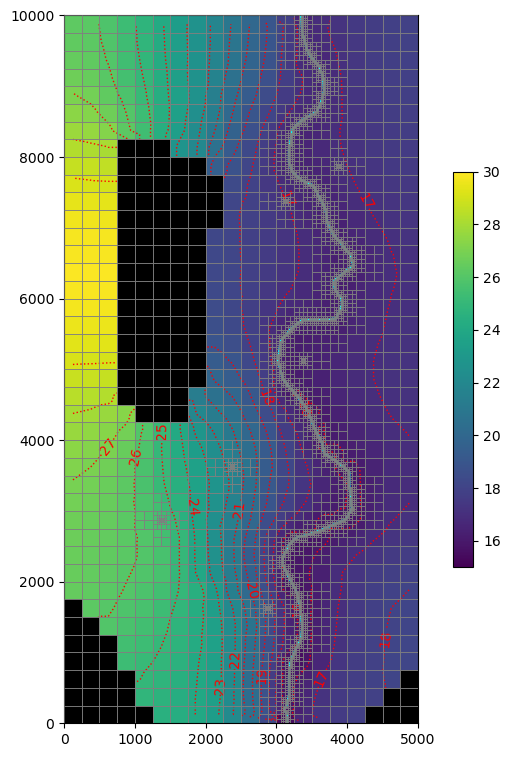

In [61]:
fig, ax = plt.subplots(
    ncols=1,
    nrows=1,
    figsize=(5, 8),
    constrained_layout=True,
    subplot_kw=dict(aspect="equal"),
)

mm = flopy.plot.PlotMapView(model=gwf, ax=ax, layer=0)
cb = mm.plot_array(gwf.dis.top.array, masked_values=[1e30], vmin=15, vmax=30)
river.plot(color="cyan", ax=mm.ax)
mm.plot_grid(lw=0.5, color="0.5", zorder=11)
mm.plot_inactive(zorder=10)
cs = mm.contour_array(
    gwf.dis.top.array,
    colors="red",
    levels=np.arange(15, 31, 1),
    linestyles=":",
    linewidths=1.0,
)
ax.clabel(
    cs,
    inline=True,
    fmt="%1.0f",
    fontsize=10,
    inline_spacing=0.5,
)
plt.colorbar(cb, ax=mm.ax, shrink=0.5)

fig.savefig(output_folder / "freyberg-quadtree-grid.png", dpi=300);